# Neural Networks (NNs) For Enhancer Activity Prediction

**Authorship:**
Adam Klie, *09/23/2021*
***
**Description:**
Notebook to train Neural Network (NN) classifiers for predicting enhancer activity
 - Currently supports training both RNNs and CNNs on one-hot encoded sequence input.
 - For RNNs, bidirectional, unidirectional and bidirectional w/ reverse complement are available for training
***
**TODOs:**
 - <font color='red'> Reconfigure notebook </font>
***

# Set-up

In [78]:
# Classics
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set random seeds
np.random.seed(333)

# Figure style
plt.style.use('presentation')

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Load local libraries
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
sys.path.append('/cellar/users/aklie/projects/EUGENE/NN/')
sys.path.append('/cellar/users/aklie/bin/make_it_train/')
import project_utils
from early_stop import EarlyStop

# Deep learning time
import torch
from torch.utils.data import TensorDataset, DataLoader
from livelossplot import PlotLosses
from torchinfo import summary

# Check for GPU
print("Using a GPU? {}".format(torch.cuda.is_available()))
if torch.cuda.is_available():
    print("Device number [0-7]: {}".format(torch.cuda.current_device()))
    print("Running on {} devices".format(torch.cuda.device_count()))

Using a GPU? True
Device number [0-7]: 0
Running on 1 devices


In [79]:
# Data params
DATASET = "2021_OLS_Library"  # Which dataset to look at
FEATURES = "ohe-seq"  # What features to use to train the model
LABELS = "binary"
PREPROCESS = "0.09-0.4"  # Preprocessing steps, separated by "-"
SPLIT = 0.9
SUBSET = False

In [85]:
# Architecture params
HYPERPARAM = "baseline"
ARCHITECTURE = "EUGENE_biLSTM"
MAX_EPOCHS = 100
BATCH_SIZE=256
TUNE = False
EPOCHS_TRAINED = 0
PATIENCE = 3
RECURRENT = True
BIDIRECTIONAL = True

In [81]:
# Out directory
OUTDIR="{}_{}_{}_{}".format(PREPROCESS, FEATURES, HYPERPARAM, ARCHITECTURE)
if not os.path.exists(OUTDIR):
    print("Making directory {}".format(OUTDIR))
    os.makedirs(OUTDIR)
else:
    print("Directory already exists")

Making directory 0.09-0.4_ohe-seq_baseline_EUGENE_RNN


# Load train and validation data

In [83]:
# Load train and val
X_train = np.load('../data/{0}/{1}/{2}_X-train-{3}_{4}.npy'.format(DATASET, FEATURES.replace("-", "_"), PREPROCESS, SPLIT, FEATURES))
y_train = np.loadtxt('../data/{0}/{1}/{2}_y-train-{3}_{1}.txt'.format(DATASET, LABELS, PREPROCESS, SPLIT), dtype=int)
X_test = np.load('../data/{0}/{1}/{2}_X-test-{3}_{4}.npy'.format(DATASET, FEATURES.replace("-", "_"), PREPROCESS, round(1-SPLIT, 1), FEATURES))
y_test = np.loadtxt('../data/{0}/{1}/{2}_y-test-{3}_{1}.txt'.format(DATASET, LABELS, PREPROCESS, round(1-SPLIT, 1)), dtype=int)
                                                                         
# need to fix this in the EDA
if not RECURRENT:
    X_train = np.transpose(X_train, axes=(0, 2, 1))
    X_test = np.transpose(X_test, axes=(0, 2, 1))

if BIDIRECTIONAL:
    print("Training bidirectional model, loading reverse seqs")
    X_train_rev = np.load('../data/{0}/{1}/{2}_X-train-{3}_{4}-rev.npy'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), PREPROCESS, SPLIT, FEATURES))
    X_test_rev = np.load('../data/{0}/{1}/{2}_X-test-{3}_{4}-rev.npy'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), PREPROCESS, round(1-SPLIT, 1), FEATURES))
    #X_train_rev = np.transpose(X_train_rev, axes=(0, 2, 1))
    #X_test_rev = np.transpose(X_test_rev, axes=(0, 2, 1))
    print(X_train_rev.shape, X_test_rev.shape)
    
# Check em
X_train.shape, y_train.shape, X_test.shape, y_test.shape

Training bidirectional model, loading reverse seqs
(177793, 66, 4) (19755, 66, 4)


((177793, 66, 4), (177793,), (19755, 66, 4), (19755,))

# Train a CNN classifier

#### <u> **Choose the model architecture** </u> 

In [86]:
if ARCHITECTURE == "lstm":
    print("Loading a lstm RNN model")
    from models import lstm
    #eugene = lstm(bidirectional=True, hidden_size=64, num_layers=3)
    eugene = lstm()
if ARCHITECTURE == "EUGENE_biLSTM":
    print("Loading a EUGENE_biLSTM RNN model")
    from models import EUGENE_biLSTM
    eugene = EUGENE_biLSTM()
elif ARCHITECTURE == "EUGENE":
    print("Loading a EUGENE CNN model")
    from models import EUGENE
    eugene = EUGENE()
elif ARCHITECTURE == "DeepSea":
    print("Loading a DeepSea CNN model")
    from models import DeepSea
    eugene = DeepSea()
else:
    print("{} is not a currently supported model architecture".format(ARCHITECTURE))
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Executing the model on:", device)

Loading a EUGENE_biLSTM RNN model
Executing the model on: cuda


#### <u> **Train a new model from scratch OR Tune a previously trained model** </u> 

In [90]:
# Instantiate model and move to gpu if available
if TUNE == False:
    print("Training a new model, initializing weights and tranferring to:", device)
    eugene.apply(project_utils.init_weights)
    eugene.to(device)
else:
    print("Tuning previous model at {}/{}_{}_{}_{}-clf_{}.pt".format(OUTDIR, PREPROCESS, FEATURES, HYPERPARAM, EPOCHS_TRAINED, ARCHITECTURE),)
    eugene.load_state_dict(torch.load("{}/{}_{}_{}_{}-clf_{}.pt".format(OUTDIR, PREPROCESS, FEATURES, HYPERPARAM, EPOCHS_TRAINED, ARCHITECTURE), map_location=torch.device(device)))
    eugene.to(device)

Training a new model, initializing weights and tranferring to: cuda


#### <u> **Test the load** </u> 

In [93]:
# Grab some seqs and outputs to test out on
indexes = np.random.choice(len(X_train), size=5)
random_seqs = torch.from_numpy(X_train[indexes, :, :]).float().to(device)
random_labels = torch.from_numpy(y_train[indexes]).to(device)
if BIDIRECTIONAL:
    random_rev_seqs = torch.from_numpy(X_train_rev[indexes, :, :]).float().to(device)
    outputs = eugene(random_seqs, random_rev_seqs).squeeze(dim=1)
    print(outputs, random_labels, project_utils.accuracy(outputs, random_labels)/len(outputs))
    print(summary(eugene, input_size=((BATCH_SIZE, 66, 4), (BATCH_SIZE, 66, 4))))
else:
    outputs = eugene(random_seqs).squeeze(dim=1)
    print(outputs, random_labels, project_utils.accuracy(outputs, random_labels)/len(outputs))
    if RECURRENT:
        print(summary(eugene, input_size=(BATCH_SIZE, 66, 4)))
    else:
        print(summary(eugene, input_size=(BATCH_SIZE, 4, 66)))

tensor([ 0.0179, -0.0099,  0.0300,  0.0399, -0.0078], device='cuda:0',
       grad_fn=<SqueezeBackward1>) tensor([1, 0, 1, 0, 0], device='cuda:0') 0.8
Layer (type:depth-idx)                   Output Shape              Param #
EUGENE_biLSTM                            --                        --
├─LSTM: 1-1                              [256, 66, 32]             4,864
├─LSTM: 1-2                              [256, 66, 32]             4,864
├─Linear: 1-3                            [256, 1]                  65
Total params: 9,793
Trainable params: 9,793
Non-trainable params: 0
Total mult-adds (M): 164.38
Input size (MB): 0.54
Forward/backward pass size (MB): 8.65
Params size (MB): 0.04
Estimated Total Size (MB): 9.23


#### <u> **Dataloading** </u> 

In [94]:
# Build Datasets objects from arrays
if BIDIRECTIONAL:
    train_dataset = TensorDataset(torch.from_numpy(np.stack([X_train, X_train_rev], axis=3)), torch.from_numpy(y_train))
    val_dataset = TensorDataset(torch.from_numpy(np.stack([X_test, X_test_rev], axis=3)), torch.from_numpy(y_test))   
else:
    # Build Datasets objects from arrays
    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [95]:
# Build Loaders from the Datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [96]:
# Check dims of loaders for correctness
print("Dimensions of training set: {} x {}".format(len(train_loader.dataset), train_loader.dataset[0][0].shape))
print("Dimensions of validation set: {} x {}".format(len(val_loader.dataset), val_loader.dataset[0][0].shape))

Dimensions of training set: 177793 x torch.Size([66, 4, 2])
Dimensions of validation set: 19755 x torch.Size([66, 4, 2])


#### <u> **Training** </u> 

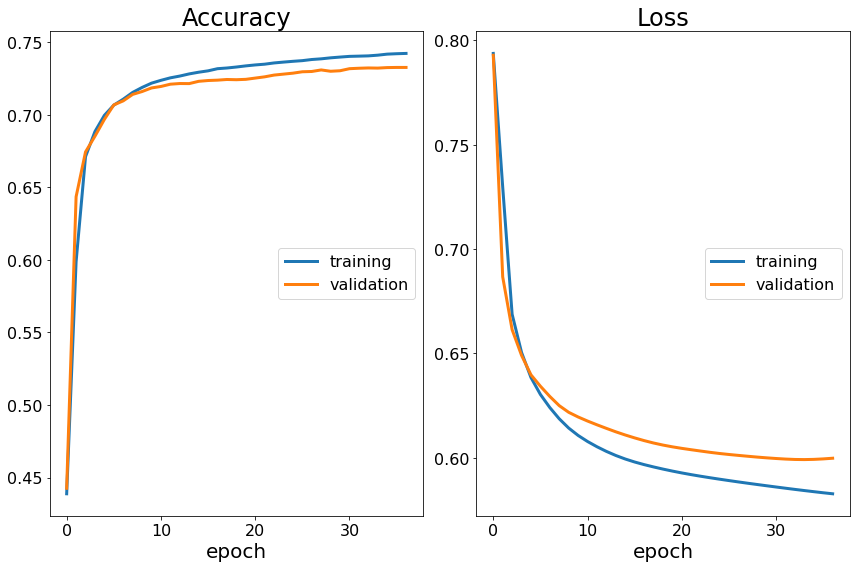

Accuracy
	training         	 (min:    0.439, max:    0.742, cur:    0.742)
	validation       	 (min:    0.443, max:    0.733, cur:    0.733)
Loss
	training         	 (min:    0.583, max:    0.794, cur:    0.583)
	validation       	 (min:    0.599, max:    0.793, cur:    0.600)
Early stopping occured at epoch 36


In [97]:
### Train/tune the model
dataloaders = {"train": train_loader, "validation": val_loader}
optimizer = torch.optim.Adam(eugene.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum', pos_weight=torch.tensor(1.3))
top_model, stop_epoch, loss_history, acc_history, _ = project_utils.train_binary_classifier(model=eugene, 
                                                                                            bidirectional=BIDIRECTIONAL,
                                                                                            dataloaders=dataloaders, 
                                                                                            device=device,
                                                                                            criterion=criterion, 
                                                                                            optimizer=optimizer, 
                                                                                            num_epoch=MAX_EPOCHS, 
                                                                                            early_stop=True, 
                                                                                            patience=PATIENCE)

# Validation Set Performance

In [98]:
prob_thresh = 0.5

In [99]:
# Get the best model results
top_model.eval()
y_outputs = {'train': torch.empty(size=(len(X_train), 1)), 'validation': torch.empty(size=(len(X_test), 1))}
y_targets = {}
for phase in ['train', 'validation']:
    len_set = len(dataloaders[phase].dataset)
    for batch, (inputs, _) in enumerate(dataloaders[phase]):
        inputs = inputs.to(device)
        if BIDIRECTIONAL:
            input_forward = inputs[:, :, :, 0].to(device)
            input_reverse = inputs[:, :, :, 1].to(device)
            outputs = top_model(input_forward.float(), input_reverse.float()).detach()
        else:
            inputs = inputs.to(device)
            outputs = top_model(inputs.float()).detach()
        if BATCH_SIZE*(batch+1) < len_set:
            y_outputs[phase][BATCH_SIZE*batch:BATCH_SIZE*(batch+1)] = outputs
        else:
            y_outputs[phase][BATCH_SIZE*batch:len_set] = outputs

y_tr_outs = y_outputs["train"]
y_tr_probs = torch.sigmoid(y_tr_outs).detach().numpy()
y_tr_preds = (y_tr_probs >= prob_thresh).astype(int)
y_outs = y_outputs["validation"]
y_probs = torch.sigmoid(y_outs).detach().numpy()
y_preds = (y_probs >= prob_thresh).astype(int)

/cellar/users/aklie/opt/miniconda3/envs/ml_env/lib/python3.8/site-packages/torch/nn/modules/rnn.py:581: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729009598/work/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [100]:
# Generate a report
if TUNE:
    iters = EPOCHS_TRAINED + stop_epoch - PATIENCE
else:
    iters = stop_epoch - PATIENCE
project_utils.classification_report(out_path="{}".format(OUTDIR),
                                    train_X=X_train, test_X=X_test, 
                                    train_y=y_train, test_y=y_test,
                                    train_preds=y_tr_preds, test_preds=y_preds,
                                    train_probs=y_tr_probs, test_probs=y_probs,
                                    iters_trained=iters)

Predictions provided, skipping them
Generating confusion matrix
Calculating classification metrics
Metric	Train	Test
Accuracy	0.7441	0.7321
Precision	0.7300	0.7170
Recall	0.7359	0.7179
F0.1-Score	0.7301	0.7170
F0.5-Score	0.7312	0.7172
F1-Score	0.7329	0.7175
F2-Score	0.7347	0.7178
F10-Score	0.7358	0.7179
Plotting PR Curve
Plotting ROC Curve
Generating report


# Save the classifier

In [102]:
torch.save(top_model.state_dict(), "{}/{}_{}_{}_{}-clf_{}.pt".format(OUTDIR, PREPROCESS, FEATURES, HYPERPARAM, iters, ARCHITECTURE))

with open("{}/{}_{}_{}_{}-clf_{}.hyperparams.txt".format(OUTDIR, PREPROCESS, FEATURES, HYPERPARAM, iters, ARCHITECTURE), "w") as f:
    if BIDIRECTIONAL:
        f.write(str(summary(eugene, input_size=((BATCH_SIZE, 66, 4), (BATCH_SIZE, 66, 4)))))
    else:
        if RECURRENT:
            f.write(str(summary(top_model, input_size=(BATCH_SIZE, 66, 4))) + "\n")
        else:
            f.write(str(summary(top_model, input_size=(BATCH_SIZE, 4, 66))) + "\n")      
    f.write("Loss function: {}".format(criterion.__str__()) + "\n")
    f.write("Positive weight: {}".format(criterion.pos_weight) + "\n")
    f.write("Optimizer params: {}".format(optimizer.defaults.__str__()))

# References

1. Ref 1
2. Ref 1

# Scratch

In [ ]:
# Current livelossplot compatible training script
def train_model(model, criterion, optimizer, num_epoch, early_stop=False, patience=3):
    liveloss = PlotLosses()
    loss_history, acc_history = {}, {}
    if early_stop:
        print("Using early stopping with a patience of {}".format(patience))
        stop = EarlyStop(patience)
        e_stop = False
    for epoch in range(num_epoch):
        logs = {}
        for phase in ['train', 'validation']:

            if phase == 'train' and epoch > 0:
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_acc = 0.0
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                outputs = model(inputs.float())
                targets = targets.unsqueeze(dim=1).to(device)
                loss = criterion(outputs, targets.float())
                if phase == 'train' and epoch > 0:
                    optimizer.zero_grad()
                    loss.backward()                
                    optimizer.step()          
                
                running_loss += loss.item()
                running_acc += project_utils.accuracy(outputs, targets)
            
            len_dataset = len(dataloaders[phase].dataset)
            epoch_loss = running_loss / len_dataset
            epoch_acc = running_acc / len_dataset
                
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'
                if early_stop:
                    e_stop, best_model = stop(epoch_loss, model)
                    
            logs[prefix + 'loss'] = epoch_loss
            logs[prefix + 'acc'] = epoch_acc
            
            loss_history.setdefault(phase, []).append(epoch_loss)
            acc_history.setdefault(phase, []).append(epoch_acc)
            
        liveloss.update(logs)
        liveloss.send()
        if early_stop:
            if e_stop:
                print("Early stopping occured at epoch {}".format(epoch))
                break
        best_model = model
            
    return best_model, epoch, loss_history, acc_history, liveloss